# Business Problem

SYL bank is one of Australia's largest banks. Currently, the loan applications which come in to their various branches are processed manually. The decision whether to grant a loan or not is subjective and due to a lot of applications coming in, it is getting harder for them to decide the loan grant status. Thus, they want to build an automated machine learning solution which will look at different factors and decide whether to grant loan or not to the respective individual.

In this ML problem, we will building a classification model as we have to predict if an applicant should get a loan or not. We will look at various factors of the applicant like credit score, past history and from those we will try to predict the loan granting status. We will also cleanse the data and fill in the missing values so that our ML model performs as expected. Thus we will be giving out a probability score along with Loan Granted or Loan Refused output from the model.

## Machine Learning Perspective

This business problem falls under:
- Supervised Learning
- Classification [ Binary ]

## Solution WorkFlow

- UNDERSTANDING PROBLEM STATEMENT
- SETTING UP THE WORKING ENVOIRNMENT
- DATA INGESTION / SOURCING
- EDA ( EXPLORATORY DATA ANALYSIS)
    - OUTLIER DETECTION
    - CORRELATIONS
    - MISSING VALUES
- DATA PREPARATION
- MODEL BUILDING
- MODEL EVALUATION
- FINALIZING THE MODEL AND SAVE IT
- PRODUCTIONIZATION (IN-GENERAL, NOT PERFORMED HERE)

### SETTING UP THE WORKING ENVOIRNMENT

In [235]:
# DATA MANIPULATION LIBRARIES
import pandas as pd
import numpy as np
import os

# data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot

# sklearn - final data preparation libraries
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelBinarizer, StandardScaler, OrdinalEncoder
from sklearn import preprocessing

# imblance dataset preparation libraries
from imblearn.over_sampling import SMOTE

#model building libraries
from sklearn.linear_model import LogisticRegression, RidgeClassifier, PassiveAggressiveClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from xgboost import plot_importance


# model metrics
from sklearn.metrics import confusion_matrix,roc_curve,roc_auc_score,classification_report
from sklearn import metrics

# statistics
import statistics
from scipy.stats import boxcox

# model saving
import joblib

import operator

### DATA SOURCING

In [120]:
# Reading the dataset
data = pd.read_csv('D:\\github\\1-DataSets\\loan eligibility prediction\\LoansTrainingSetV2.csv',
                  low_memory=False)

### EDA - Exploratory Data Analysis

#### Information / summary of the data

In [121]:
# first five rows
data.head()

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Years in current job,Home Ownership,Annual Income,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,6cf51492-02a2-423e-b93d-676f05b9ad53,7c202b37-2add-44e8-9aea-d5b119aea935,Loan Refused,12232,Short Term,7280.0,< 1 year,Rent,46643.0,Debt Consolidation,777.39,18.0,10.0,12,0,6762,7946,0.0,0.0
1,552e7ade-4292-4354-9ff9-c48031697d72,e7217b0a-07ac-47dd-b379-577b5a35b7c6,Loan Refused,25014,Long Term,7330.0,10+ years,Home Mortgage,81099.0,Debt Consolidation,892.09,26.7,NaN,14,0,35706,77961,0.0,0.0
2,9b5e32b3-8d76-4801-afc8-d729d5a2e6b9,0a62fc41-16c8-40b5-92ff-9e4b763ce714,Loan Refused,16117,Short Term,7240.0,9 years,Home Mortgage,60438.0,Home Improvements,1244.02,16.7,32.0,11,1,11275,14815,1.0,0.0
3,5419b7c7-ac11-4be2-a8a7-b131fb6d6dbe,30f36c59-5182-4482-8bbb-5b736849ae43,Loan Refused,11716,Short Term,7400.0,3 years,Rent,34171.0,Debt Consolidation,990.94,10.0,NaN,21,0,7009,43533,0.0,0.0
4,1450910f-9495-4fc9-afaf-9bdf4b9821df,70c26012-bba5-42c0-8dcb-75295ada31bb,Loan Refused,9789,Long Term,6860.0,10+ years,Home Mortgage,47003.0,Home Improvements,503.71,16.7,25.0,13,1,16913,19553,1.0,0.0


In [122]:
# shape of the data
data.shape

(111107, 19)

In [123]:
# information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111107 entries, 0 to 111106
Data columns (total 19 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Loan ID                       111107 non-null  object 
 1   Customer ID                   111107 non-null  object 
 2   Loan Status                   111107 non-null  object 
 3   Current Loan Amount           111107 non-null  int64  
 4   Term                          111107 non-null  object 
 5   Credit Score                  89769 non-null   float64
 6   Years in current job          106414 non-null  object 
 7   Home Ownership                111107 non-null  object 
 8   Annual Income                 89769 non-null   float64
 9   Purpose                       111107 non-null  object 
 10  Monthly Debt                  111107 non-null  object 
 11  Years of Credit History       111107 non-null  float64
 12  Months since last delinquent  52104 non-null

#### Dropping the duplicates - "Loan ID"

In [124]:
data.drop_duplicates(subset='Loan ID',
                    keep='first',
                    inplace=True)

In [125]:
data.shape

(88910, 19)

There are about 21k records which are duplicate, which is a huge number 

#### Target Variable 

In [126]:
status = data['Loan Status'].value_counts()

In [127]:
status

Loan Given      63737
Loan Refused    25173
Name: Loan Status, dtype: int64

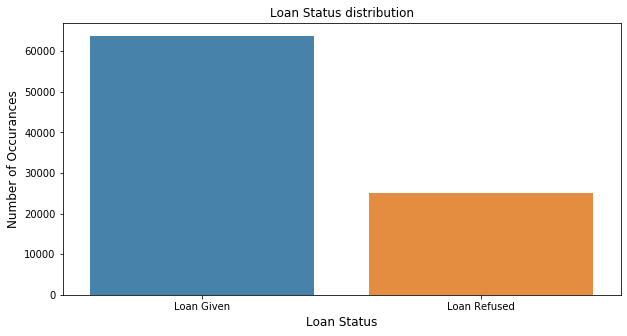

In [128]:
plt.figure(figsize=(10,5))
sns.barplot(status.index,
           status.values,
           alpha=0.9)
plt.title('Loan Status distribution')
plt.xlabel('Loan Status',fontsize=12)
plt.ylabel('Number of Occurances',fontsize=12)
plt.savefig('D:\\github\\6-Loan Eligibility Prediction\\Loan-Eligibility-Prediction-Using-Gradient-Boosting-Classifier\\plots\\1_targetVariable_Distribution.png')

We can see that ,our target variable is imbalanced

#### Attribute - Current Loan Amount

In [129]:
data['Current Loan Amount'].describe()

count    8.891000e+04
mean     1.433878e+07
std      3.502996e+07
min      4.910000e+02
25%      8.283000e+03
50%      1.435500e+04
75%      2.448500e+04
max      1.000000e+08
Name: Current Loan Amount, dtype: float64

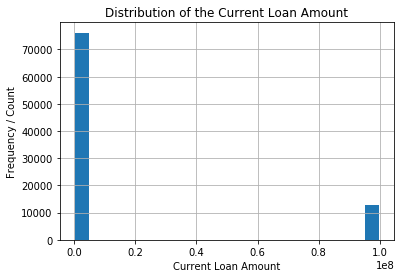

In [130]:
data['Current Loan Amount'].plot.hist(grid=True,
                                     bins=20,
                                     rwidth=0.9)
plt.title('Distribution of the Current Loan Amount')
plt.xlabel('Current Loan Amount')
plt.ylabel('Frequency / Count')
plt.savefig('D:\\github\\6-Loan Eligibility Prediction\\Loan-Eligibility-Prediction-Using-Gradient-Boosting-Classifier\\plots\\2_custLoanAmt_Distribution_outliers.png')

From this plot , we can say that there are few outliers in the data

In [131]:
# finding the outliers
q1 = data['Current Loan Amount'].quantile(0.25)
q3 = data['Current Loan Amount'].quantile(0.75)
iqr = q3 - q1
print('IQR of Current Loan Amount: ',iqr)

IQR of Current Loan Amount:  16202.0


In [132]:
# Outlier of the data
data['Current Loan Amount'][(data['Current Loan Amount'] > (iqr*1.5+q3))|(data['Current Loan Amount'] < (q1 - iqr*1.5))]

5044     99999999
5045     99999999
5046     99999999
5047     99999999
5048     99999999
           ...   
17777    99999999
17778    99999999
17779    99999999
17780    99999999
17781    99999999
Name: Current Loan Amount, Length: 12738, dtype: int64

In [133]:
# replacing all the outliers with 'NaN'
temp = np.array(data['Current Loan Amount'].values.tolist())

data['Current Loan Amount Temp'] = np.where(temp>9999998, 'NaN', temp).tolist()

Text(0.5, 1.0, 'Current Loan AMount Distribution')

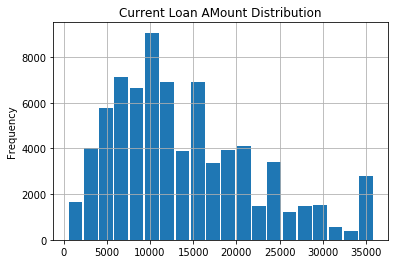

In [134]:
# getting the values which are not outliers for plotting the distribution
temp = data['Current Loan Amount Temp'][data['Current Loan Amount Temp']!='NaN'].astype(str).astype(int)

temp.plot.hist(grid=True,
              bins=20,
              rwidth=0.9)
plt.title('Current Loan AMount Distribution')

In [135]:
temp.describe()

count    76172.000000
mean     13933.915756
std       8235.921922
min        491.000000
25%       7810.000000
50%      12038.000000
75%      19351.000000
max      35875.000000
Name: Current Loan Amount Temp, dtype: float64

In [136]:
# replacing the outliers with median / 50% percentile value
temp = np.array(data['Current Loan Amount'].values.tolist())
data['Current Loan Amount'] = np.where(temp>9999998,12038,temp).tolist()

In [137]:
data = data.drop(['Current Loan Amount Temp'],
                axis=1)

#### Attribute - Term

In [138]:
status = data['Term'].value_counts()

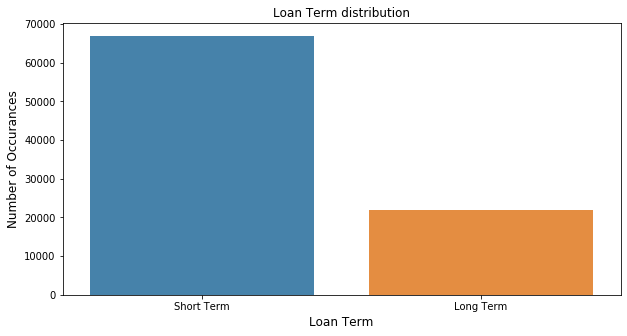

In [139]:
plt.figure(figsize=(10,5))
sns.barplot(status.index,
           status.values,
           alpha=0.9)
plt.title('Loan Term distribution')
plt.xlabel('Loan Term',fontsize=12)
plt.ylabel('Number of Occurances',fontsize=12)
plt.savefig('D:\\github\\6-Loan Eligibility Prediction\\Loan-Eligibility-Prediction-Using-Gradient-Boosting-Classifier\\plots\\3_termVar_Distribution.png')

#### Attribute - Credit Score

In [140]:
data['Credit Score'].describe()

count    67572.000000
mean      1199.199580
std       1680.813805
min        585.000000
25%        714.000000
50%        733.000000
75%        744.000000
max       7510.000000
Name: Credit Score, dtype: float64

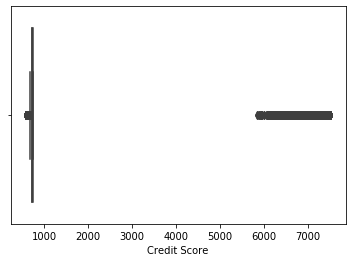

In [141]:
# Distribution of the credit core - outliers indication
sns.boxplot(data['Credit Score'])

In [142]:
# null values
data['Credit Score'].isnull().sum()

21338

In [143]:
# Filled the outliers with the value divides by 10
data['Credit Score'] = np.where(data['Credit Score']>800,
                               data['Credit Score']/10,
                               data['Credit Score'])

In [144]:
# replacing the null values with median
median_score = statistics.median(data['Credit Score'])
data['Credit Score'].fillna(median_score,
                           inplace=True)

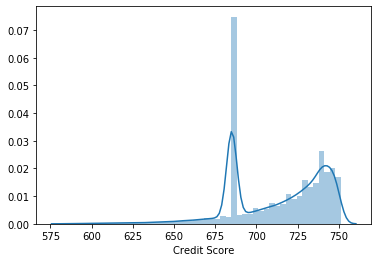

In [145]:
sns.distplot(data['Credit Score'])
plt.savefig('D:\\github\\6-Loan Eligibility Prediction\\Loan-Eligibility-Prediction-Using-Gradient-Boosting-Classifier\\plots\\4_credScoreVar_Distribution.png')

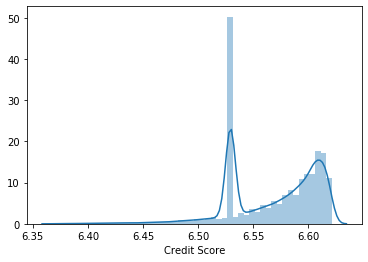

In [146]:
sns.distplot(np.log(data['Credit Score']))

From the above plot we can see that out distribution is not normal even after transformation, which indicates that our imputation stratergy is not correct

#### Attribute - 'Home Ownership'

In [147]:
data['Home Ownership'].value_counts()

Home Mortgage    43270
Rent             37395
Own Home          8075
HaveMortgage       170
Name: Home Ownership, dtype: int64

In [148]:
data['Home Ownership'] = data['Home Ownership'].str.replace('HaveMortgage','Home Mortgage', regex=True)

#### Attribute - Annual Income

In [149]:
data['Annual Income'].describe()

count    6.757200e+04
mean     7.234575e+04
std      5.836101e+04
min      4.033000e+03
25%      4.458600e+04
50%      6.149400e+04
75%      8.675025e+04
max      8.713547e+06
Name: Annual Income, dtype: float64

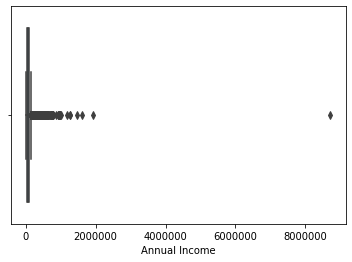

In [150]:
sns.boxplot(data['Annual Income'])

In [151]:
data['Annual Income'].quantile([0.25,0.50,0.75,0.90, 0.95, 0.99, 0.999])

0.250     44586.00
0.500     61494.00
0.750     86750.25
0.900    119916.00
0.950    147645.00
0.990    239286.96
0.999    491575.77
Name: Annual Income, dtype: float64

In [152]:
data.loc[data['Annual Income']>239287,'Annual Income'] = 239287

In [153]:
data['Annual Income'].isnull().sum()

21338

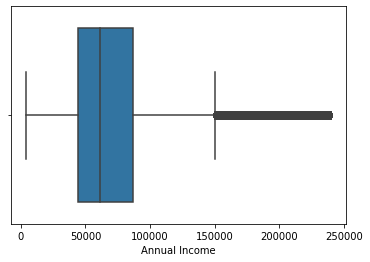

In [154]:
sns.boxplot(data['Annual Income'])
plt.savefig('D:\\github\\6-Loan Eligibility Prediction\\Loan-Eligibility-Prediction-Using-Gradient-Boosting-Classifier\\plots\\5_AnnualINCOMEVar_Distribution.png')

In [155]:
data['Annual Income'].describe()

count     67572.000000
mean      71131.756615
std       39199.679887
min        4033.000000
25%       44586.000000
50%       61494.000000
75%       86750.250000
max      239287.000000
Name: Annual Income, dtype: float64

In [156]:
data['Annual Income'].fillna(61494,inplace=True)

#### Attribute - Purpose

In [157]:
data['Purpose'].value_counts()

Debt Consolidation      70447
Home Improvements        5206
other                    4917
Other                    2850
Business Loan            1328
Buy a Car                1196
Medical Bills             955
Buy House                 559
Take a Trip               454
major_purchase            344
small_business            248
moving                    124
wedding                    99
Educational Expenses       92
vacation                   82
renewable_energy            9
Name: Purpose, dtype: int64

In [158]:
data['Purpose'] = data['Purpose'].str.replace('Other','other',regex=True)

#### Attribute - Monthly debt

In [159]:
data['Monthly Debt'].describe()

count     88910
unique    70066
top           0
freq         69
Name: Monthly Debt, dtype: object

In [160]:
pd.to_numeric(data['Monthly Debt'])

ValueError: Unable to parse string "$1051.41" at position 10

In [161]:
data['Monthly Debt'] = data['Monthly Debt'].str.replace('$','',regex=True)

In [162]:
data['Monthly Debt'] = pd.to_numeric(data['Monthly Debt'])

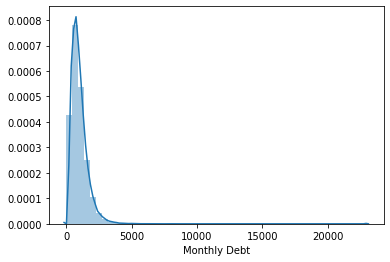

In [163]:
sns.distplot(data['Monthly Debt'])

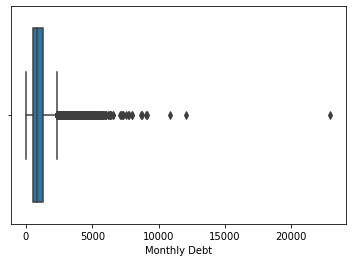

In [164]:
sns.boxplot(data['Monthly Debt'])

In [165]:
data['Monthly Debt'].quantile([0.2,0.25,0.50,0.75,0.90,0.99,0.999])

0.200     463.75000
0.250     532.22000
0.500     843.92500
0.750    1250.52750
0.900    1743.08300
0.990    3087.11100
0.999    4926.37475
Name: Monthly Debt, dtype: float64

In [166]:
data['Monthly Debt'].quantile([0.9997,0.99999])

0.99970     5978.574911
0.99999    13262.762330
Name: Monthly Debt, dtype: float64

In [167]:
data.loc[data['Monthly Debt']>4926,'Monthly Debt'] = 4926

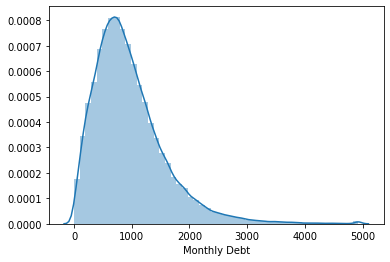

In [168]:
sns.distplot(data['Monthly Debt'])

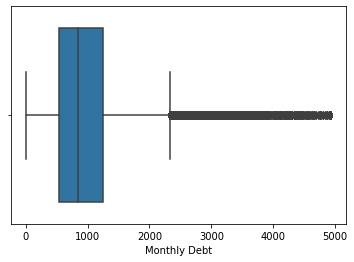

In [169]:
sns.boxplot(data['Monthly Debt'])

#### Attribute - credit History

In [170]:
data['Years of Credit History'].describe()

count    88910.000000
mean        18.315313
std          7.049175
min          3.600000
25%         13.500000
50%         17.000000
75%         21.800000
max         70.500000
Name: Years of Credit History, dtype: float64

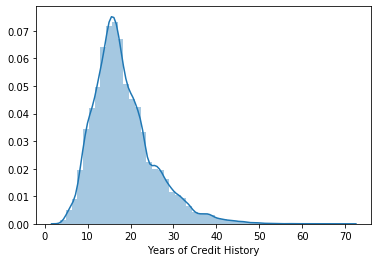

In [171]:
sns.distplot(data['Years of Credit History'])

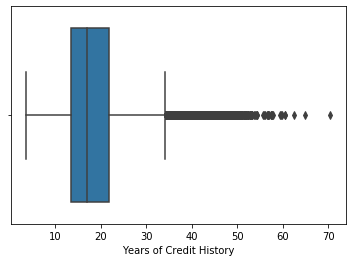

In [172]:
sns.boxplot(data['Years of Credit History'])

#### Attribute - Months since last delinquent

In [173]:
data['Months since last delinquent'].describe()

count    40404.000000
mean        35.080289
std         22.008583
min          0.000000
25%         16.000000
50%         32.000000
75%         51.000000
max        176.000000
Name: Months since last delinquent, dtype: float64

In [174]:
data['Months since last delinquent'].isnull().sum()

48506

In [175]:
data['Months since last delinquent'].fillna(32,inplace=True)

#### Attribute - Number of open accounts

In [176]:
data['Number of Open Accounts'].describe()

count    88910.000000
mean        11.110348
std          4.978461
min          0.000000
25%          8.000000
50%         10.000000
75%         14.000000
max         76.000000
Name: Number of Open Accounts, dtype: float64

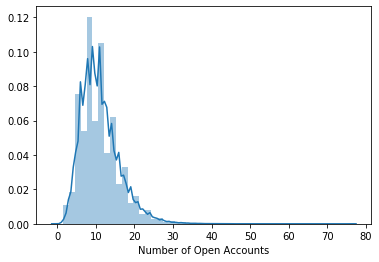

In [177]:
sns.distplot(data['Number of Open Accounts'])

In [178]:
data['Number of Open Accounts'].quantile([0.2,0.5,0.7,0.90,0.95,0.99,0.999,1])

0.200     7.0
0.500    10.0
0.700    13.0
0.900    18.0
0.950    20.0
0.990    26.0
0.999    36.0
1.000    76.0
Name: Number of Open Accounts, dtype: float64

In [179]:
data.loc[data['Number of Open Accounts']>36,'Number of Open Accounts'] = 36

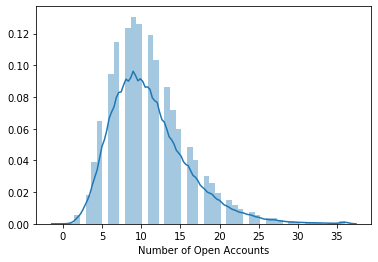

In [180]:
sns.distplot(data['Number of Open Accounts'])

#### Attribute - Number of Credit problems

In [181]:
data['Number of Credit Problems'].describe()

count    88910.000000
mean         0.160477
std          0.473746
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         15.000000
Name: Number of Credit Problems, dtype: float64

In [182]:
data['Number of Credit Problems'].value_counts()

0     77057
1     10271
2      1092
3       311
4       101
5        46
6        14
7         6
9         4
10        3
8         2
15        1
12        1
11        1
Name: Number of Credit Problems, dtype: int64

#### Attribute - Current Credit Balance

In [183]:
data['Current Credit Balance'].describe()

count    8.891000e+04
mean     1.543593e+04
std      1.965873e+04
min      0.000000e+00
25%      5.949000e+03
50%      1.103900e+04
75%      1.930100e+04
max      1.730472e+06
Name: Current Credit Balance, dtype: float64

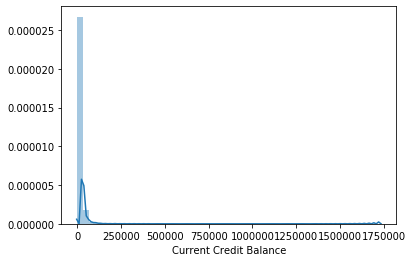

In [184]:
sns.distplot(data['Current Credit Balance'])

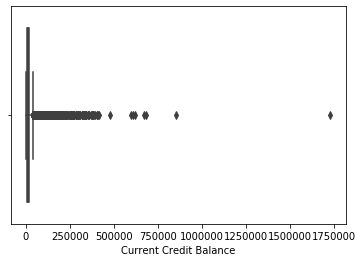

In [185]:
sns.boxplot(data['Current Credit Balance'])

In [186]:
data['Current Credit Balance'].quantile([0.2,0.5,0.7,0.9,0.99,0.999])

0.200      5030.000
0.500     11039.000
0.700     17102.900
0.900     30843.500
0.990     81007.190
0.999    227670.033
Name: Current Credit Balance, dtype: float64

In [187]:
data.loc[data['Current Credit Balance']>81007,'Current Credit Balance'] = 81007

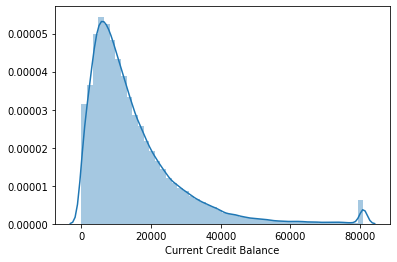

In [188]:
sns.distplot(data['Current Credit Balance'])

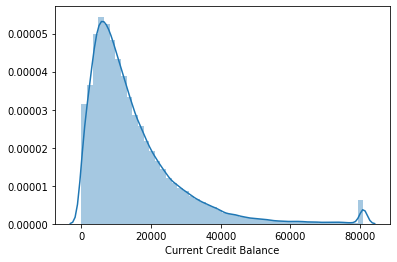

In [189]:
sns.distplot((data['Current Credit Balance']))

#### Attribute - Maximum open Credit

In [190]:
data['Maximum Open Credit'].value_counts()

0        610
14382     10
11044     10
10782     10
17464     10
        ... 
31176      1
10764      1
5065       1
56631      1
32663      1
Name: Maximum Open Credit, Length: 46625, dtype: int64

In [191]:
pd.to_numeric(data['Maximum Open Credit'])

ValueError: Unable to parse string "#VALUE!" at position 4930

In [192]:
data['Maximum Open Credit'] = data['Maximum Open Credit'].replace('#VALUE!',np.nan,regex=True)

In [193]:
data['Maximum Open Credit'].isnull().sum()

2

In [194]:
data['Maximum Open Credit'].fillna(35965,inplace=True)

In [195]:
data['Maximum Open Credit'] = pd.to_numeric(data['Maximum Open Credit'])

In [196]:
data['Maximum Open Credit'].describe()

count    8.891000e+04
mean     3.596531e+04
std      4.041760e+05
min      0.000000e+00
25%      1.277525e+04
50%      2.178150e+04
75%      3.636700e+04
max      6.998809e+07
Name: Maximum Open Credit, dtype: float64

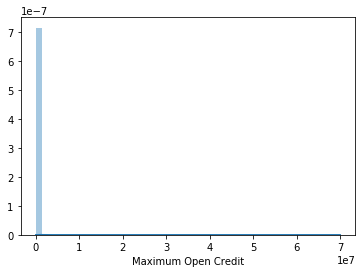

In [197]:
sns.distplot(data['Maximum Open Credit'])

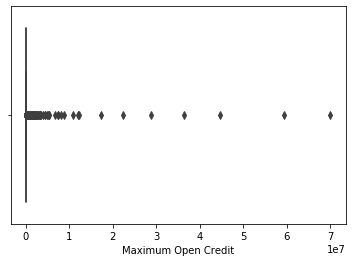

In [198]:
sns.boxplot(data['Maximum Open Credit'])

In [199]:
data['Maximum Open Credit'].quantile([0.25,0.50,0.75,0.90,0.99,1])

0.25       12775.25
0.50       21781.50
0.75       36367.00
0.90       56956.50
0.99      171423.91
1.00    69988086.00
Name: Maximum Open Credit, dtype: float64

In [200]:
data['Maximum Open Credit'].quantile([0.90,0.95,0.97,0.98,0.99])

0.90     56956.50
0.95     76600.80
0.97     95694.73
0.98    114682.56
0.99    171423.91
Name: Maximum Open Credit, dtype: float64

In [201]:
data.loc[data['Maximum Open Credit']>114682,'Maximum Open Credit'] = 114682

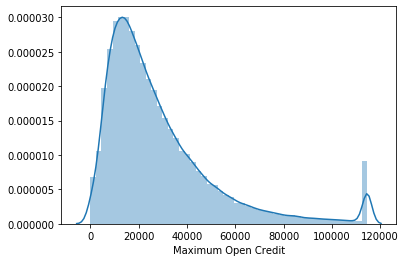

In [202]:
sns.distplot(data['Maximum Open Credit'])

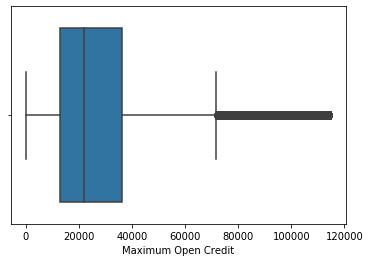

In [203]:
sns.boxplot(data['Maximum Open Credit'])

#### Attribute - Bankrupticies

In [204]:
data['Bankruptcies'].describe()

count    88718.000000
mean         0.112672
std          0.343300
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          7.000000
Name: Bankruptcies, dtype: float64

In [205]:
data['Bankruptcies'].value_counts()

0.0    79323
1.0     8936
2.0      353
3.0       80
4.0       19
5.0        5
7.0        1
6.0        1
Name: Bankruptcies, dtype: int64

In [206]:
data['Bankruptcies'].unique()

array([ 0.,  1., nan,  2.,  4.,  3.,  5.,  7.,  6.])

In [207]:
data['Bankruptcies'].isnull().sum()

192

In [208]:
data['Bankruptcies'].fillna(3,inplace=True)

#### Attribute - Tax Liens

In [209]:
data['Tax Liens'].describe()

count    88902.000000
mean         0.028222
std          0.257533
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         15.000000
Name: Tax Liens, dtype: float64

In [210]:
data['Tax Liens'].value_counts()

0.0     87274
1.0      1132
2.0       305
3.0        99
4.0        52
5.0        17
6.0         9
7.0         5
9.0         4
8.0         2
15.0        1
11.0        1
10.0        1
Name: Tax Liens, dtype: int64

In [211]:
data['Tax Liens'].isnull().sum()

8

In [212]:
data['Tax Liens'].fillna(1,inplace=True)

#### Encoding

In [213]:
cat_cols = ['Term','Years in current job','Home Ownership','Purpose']

for c in cat_cols:
    data[c] = pd.factorize(data[c])[0]

In [214]:
data.head()

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Years in current job,Home Ownership,Annual Income,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,6cf51492-02a2-423e-b93d-676f05b9ad53,7c202b37-2add-44e8-9aea-d5b119aea935,Loan Refused,12232,0,728.0,0,0,46643.0,0,777.39,18.0,10.0,12,0,6762,7946,0.0,0.0
1,552e7ade-4292-4354-9ff9-c48031697d72,e7217b0a-07ac-47dd-b379-577b5a35b7c6,Loan Refused,25014,1,733.0,1,1,81099.0,0,892.09,26.7,32.0,14,0,35706,77961,0.0,0.0
2,9b5e32b3-8d76-4801-afc8-d729d5a2e6b9,0a62fc41-16c8-40b5-92ff-9e4b763ce714,Loan Refused,16117,0,724.0,2,1,60438.0,1,1244.02,16.7,32.0,11,1,11275,14815,1.0,0.0
3,5419b7c7-ac11-4be2-a8a7-b131fb6d6dbe,30f36c59-5182-4482-8bbb-5b736849ae43,Loan Refused,11716,0,740.0,3,0,34171.0,0,990.94,10.0,32.0,21,0,7009,43533,0.0,0.0
4,1450910f-9495-4fc9-afaf-9bdf4b9821df,70c26012-bba5-42c0-8dcb-75295ada31bb,Loan Refused,9789,1,686.0,1,1,47003.0,1,503.71,16.7,25.0,13,1,16913,19553,1.0,0.0


In [215]:
data.drop(['Loan ID','Customer ID'],
         axis=1,
         inplace=True)

In [216]:
data.head()

,Loan Status,Current Loan Amount,Term,Credit Score,Years in current job,Home Ownership,Annual Income,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,Loan Refused,12232,0,728.0,0,0,46643.0,0,777.39,18.0,10.0,12,0,6762,7946,0.0,0.0
1,Loan Refused,25014,1,733.0,1,1,81099.0,0,892.09,26.7,32.0,14,0,35706,77961,0.0,0.0
2,Loan Refused,16117,0,724.0,2,1,60438.0,1,1244.02,16.7,32.0,11,1,11275,14815,1.0,0.0
3,Loan Refused,11716,0,740.0,3,0,34171.0,0,990.94,10.0,32.0,21,0,7009,43533,0.0,0.0
4,Loan Refused,9789,1,686.0,1,1,47003.0,1,503.71,16.7,25.0,13,1,16913,19553,1.0,0.0


In [217]:
lb_style = LabelBinarizer()
lb_results = lb_style.fit_transform(data['Loan Status'])

In [218]:
y = lb_results.ravel()

#### Scaling

In [219]:
data.drop('Loan Status', axis=1, inplace =True)

In [220]:
data.head()

,Current Loan Amount,Term,Credit Score,Years in current job,Home Ownership,Annual Income,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,12232,0,728.0,0,0,46643.0,0,777.39,18.0,10.0,12,0,6762,7946,0.0,0.0
1,25014,1,733.0,1,1,81099.0,0,892.09,26.7,32.0,14,0,35706,77961,0.0,0.0
2,16117,0,724.0,2,1,60438.0,1,1244.02,16.7,32.0,11,1,11275,14815,1.0,0.0
3,11716,0,740.0,3,0,34171.0,0,990.94,10.0,32.0,21,0,7009,43533,0.0,0.0
4,9789,1,686.0,1,1,47003.0,1,503.71,16.7,25.0,13,1,16913,19553,1.0,0.0


In [221]:
X_scaled = preprocessing.scale(data)

In [223]:
print(X_scaled)

[[-0.1869176  -0.57302977  0.53146073 ... -0.88648828 -0.32295035
  -0.10986114]
 [ 1.48349848  1.74511004  0.70648654 ...  2.15375685 -0.32295035
  -0.10986114]
 [ 0.32079375 -0.57302977  0.39144008 ... -0.58821729  2.39304617
  -0.10986114]
 ...
 [ 1.40247376 -0.57302977  1.16155365 ...  1.08612124 -0.32295035
  -0.10986114]
 [-1.1281112  -0.57302977  0.32142975 ... -0.43159136 -0.32295035
  -0.10986114]
 [ 0.62515919 -0.57302977  0.18140911 ... -0.31426304 -0.32295035
   3.77085174]]


#### Splitting into train and test

In [224]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.33, random_state=22)

### Modelling

In [225]:
def classify(est, x, y, X_test, y_test):
    est.fit(x,y)
    y2 = est.predict_proba(X_test)
    y1 = est.predict(X_test)
    
    print('Accuracy: ',metrics.accuracy_score(y_test,y1))
    print('Area Under the ROC Curve: ',metrics.roc_auc_score(y_test,y2[:,1]))
    print('F-score: ',metrics.f1_score(y_test,y1))
    print(" ")
    print('Classification report:')
    print(metrics.classification_report(y_test,y1))
    print(" ")
    print('Evaluation by cross-validation:')
    print(cross_val_score(est, x, y))
    return est,y1,y2[:,1]

In [233]:
def feat_importance(estimator):
    feature_importance = {}
    for index, name in enumerate(data.columns):
        feature_importance[name] = estimator.feature_importances_[index]
    sorted_x = sorted(feature_importance.items(),key=operator.itemgetter(1),reverse=True)
    
    return sorted_x

In [239]:
#Model to  predict the ROC curve for various models and finding the best one
def run_models(X_train, y_train, X_test, y_test, model_type = 'Non-balanced'):
    
    clfs = {'GradientBoosting': GradientBoostingClassifier(max_depth= 6, n_estimators=100, max_features = 0.3),
            'LogisticRegression' : LogisticRegression(),
            #'GaussianNB': GaussianNB(),
            'RandomForestClassifier': RandomForestClassifier(n_estimators=10),
            'XGBClassifier': XGBClassifier()
            }
    cols = ['model','matthews_corrcoef', 'roc_auc_score', 'precision_score', 'recall_score','f1_score']

    models_report = pd.DataFrame(columns = cols)
    conf_matrix = dict()

    for clf, clf_name in zip(clfs.values(), clfs.keys()):

        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)
        y_score = clf.predict_proba(X_test)[:,1]

        print('computing {} - {} '.format(clf_name, model_type))

        tmp = pd.Series({'model_type': model_type,
                         'model': clf_name,
                         'roc_auc_score' : metrics.roc_auc_score(y_test, y_score),
                         'matthews_corrcoef': metrics.matthews_corrcoef(y_test, y_pred),
                         'precision_score': metrics.precision_score(y_test, y_pred),
                         'recall_score': metrics.recall_score(y_test, y_pred),
                         'f1_score': metrics.f1_score(y_test, y_pred)})

        models_report = models_report.append(tmp, ignore_index = True)
        conf_matrix[clf_name] = pd.crosstab(y_test, y_pred, rownames=['True'], colnames= ['Predicted'], margins=False)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score, drop_intermediate = False, pos_label = 1)

        plt.figure(1, figsize=(6,6))
        plt.xlabel('false positive rate')
        plt.ylabel('true positive rate')
        plt.title('ROC curve - {}'.format(model_type))
        plt.plot(fpr, tpr, label = clf_name )
        plt.legend(loc=2, prop={'size':11})
    plt.plot([0,1],[0,1], color = 'black')
    
    return models_report, conf_matrix


#### Logisitc regression

In [226]:
logit, y_p, y_p2 = classify(LogisticRegression(),X_train,y_train,X_test,y_test)

Accuracy:  0.7214478034150166
Area Under the ROC Curve:  0.6625479727401163
F-score:  0.20596521908092877
 
Classification report:
              precision    recall  f1-score   support

           0       0.73      0.96      0.83     20914
           1       0.57      0.13      0.21      8427

    accuracy                           0.72     29341
   macro avg       0.65      0.54      0.52     29341
weighted avg       0.68      0.72      0.65     29341

 
Evaluation by cross-validation:
[0.72704381 0.72679201 0.7260366  0.72838677 0.72576177]


#### XGB Boosting

In [228]:
xgb, y_pred_b, y_pred_2b = classify(XGBClassifier(),X_train,y_train,X_test,y_test)

Accuracy:  0.7281960396714495
Area Under the ROC Curve:  0.739142948436016
F-score:  0.368716852687406
 
Classification report:
              precision    recall  f1-score   support

           0       0.76      0.91      0.83     20914
           1       0.55      0.28      0.37      8427

    accuracy                           0.73     29341
   macro avg       0.66      0.59      0.60     29341
weighted avg       0.70      0.73      0.70     29341

 
Evaluation by cross-validation:
[0.73409434 0.73501763 0.73040121 0.72872251 0.72928733]


In [229]:
print(xgb.feature_importances_)

[0.12968628 0.36096364 0.10245316 0.02585484 0.04199966 0.04839781
 0.02924057 0.02762489 0.02723742 0.02662258 0.02573361 0.02379899
 0.02840273 0.03239848 0.02505491 0.04453044]


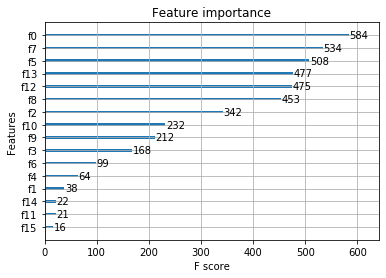

In [231]:
plot_importance(xgb)
pyplot.show()

In [236]:
feat1 = feat_importance(xgb)

In [238]:
feat1

[('Term', 0.36096364),
 ('Current Loan Amount', 0.12968628),
 ('Credit Score', 0.10245316),
 ('Annual Income', 0.048397806),
 ('Tax Liens', 0.04453044),
 ('Home Ownership', 0.04199966),
 ('Maximum Open Credit', 0.03239848),
 ('Purpose', 0.029240575),
 ('Current Credit Balance', 0.02840273),
 ('Monthly Debt', 0.027624886),
 ('Years of Credit History', 0.027237417),
 ('Months since last delinquent', 0.026622584),
 ('Years in current job', 0.02585484),
 ('Number of Open Accounts', 0.025733605),
 ('Bankruptcies', 0.025054915),
 ('Number of Credit Problems', 0.02379899)]

#### Models Evaluation

computing GradientBoosting - Non-balanced 
computing LogisticRegression - Non-balanced 
computing RandomForestClassifier - Non-balanced 
computing XGBClassifier - Non-balanced 


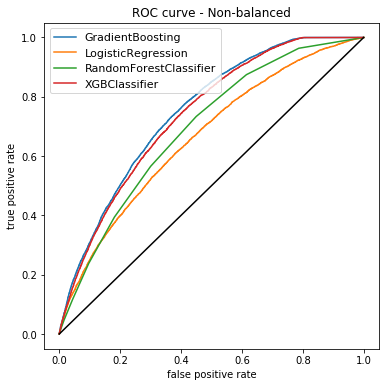

In [241]:
model_report, conf_mat = run_models(X_train, y_train, X_test, y_test, model_type = 'Non-balanced')

#### Balancing the data set

computing GradientBoosting - Balanced 
computing LogisticRegression - Balanced 
computing RandomForestClassifier - Balanced 
computing XGBClassifier - Balanced 


['GBM_Model_version1.pkl']

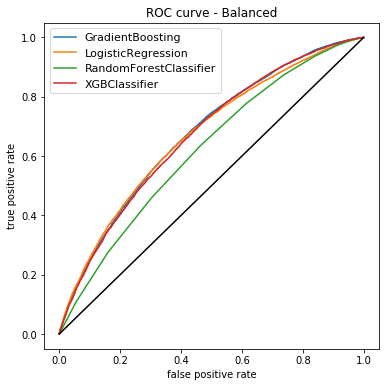

In [242]:
###########Synthetically balancing the dataset##################


index_split = int(len(X_scaled)/2)
X_train, y_train = SMOTE().fit_sample(X_scaled[0:index_split, :], y[0:index_split])
X_test, y_test = X_scaled[index_split:], y[index_split:]

models_report_bal, conf_matrix_bal = run_models(X_train, y_train, X_test, y_test, model_type = 'Balanced')


################Now we  know that GBM model performed the best so 
# save model
gbm=GradientBoostingClassifier(max_depth= 6, n_estimators=100, max_features = 0.3)
gbm.fit(X_scaled, y)
joblib.dump(gbm, 'GBM_Model_version1.pkl')
# load model
#gbm_pickle = joblib.load('GBM_Model_version1.pkl')